---
title: AUC和ROC的解读和numpy实现
date: 2018-09-18 18:17:55
tags: [numpy]
toc: true
xiongzhang: true
xiongzhang_images: [main.jpg]

---
<span></span>
<!-- more -->

### 实际例子

我们从例子开始往往能够更容易理解问题:

下面的表格是一个经过分类器分类的样本数据, Class这一列表示真实的分类, Score这一列表示分类器预测样本为p的概率, 下面我们用ROC和AUC来评估这个分类器, 主要是为了演示一下AUC和ROC是如何得到的。

<img src="imgs/samples.png">

我们的程序主要依赖是:

- python3.6
- numpy1.9

我们把这个样本数据保存到一个数组中:

In [124]:
import numpy as np

data = np.array([
    [1, .9],
    [1, .8],
    [0, .7],
    [1, .6],
    [1, .55],
    [1, .54],
    [0, .53],
    [0, .52],
    [1, .51],
    [0, .505],
    [1, .4],
    [0, .39],
    [1, .38],
    [0, .37],
    [0, .36],
    [0, .35],
    [1, .34],
    [0, .33],
    [1, .30],
    [0, .1]
])

data = np.r_[data, data, data, data]
data = np.r_[data, data, data, data]
data = np.r_[data, data, data, data]

### 基础知识

<img src="imgs/confusion-matrix.png"/>



大家应该都见过上面的混淆矩阵, 假设这是一个二分类任务, 样本分为正负两种(True Class), 当然我们的分类器也是把样本分为这两种(Hypothesized class), 因为分类器不可能百分百准确, 所以可以得到四个指标: 

- True Positive: 实际分类是Positive, 预测结果也是Positive
- False Positive: 实际分类是Negtive, 预测结果是Positive
- False Negtive: 实际分类是Positive, 预测结果是Negtive
- True Negtive: 实际分类是Negtive, 预测结果是Negtive

> (True和False表示预测结果是否正确, Positive和Negetive表示样本预测的分类)

下面用函数`metrics`来计算所有的四个指标, 参数是分类阈值`y`

In [12]:
def metrics(data, y):
    # 预测结果
    predicts = data[:, 1] >= y
    # true pos
    tp = sum(data[predicts, 0])
    # false pos
    fp = data[predicts, 0].shape[0] - tp
    # false neg
    fn = sum(data[~predicts, 0])
    # true neg
    tn = data[~predicts, 0].shape[0] - fn
    return {
        'tp':tp,
        'fp':fp,
        'tn':tn,
        'fn':fn
    }

In [13]:
metrics(data, .5)

{'tp': 6.0, 'fp': 4.0, 'tn': 6.0, 'fn': 4.0}

### 理论知识

ROC(Receiver Operating Characteristic)和AUC是比较常用的两种分类器的性能评价指标。他们和我们常用的Precision/recall/f-score之间是有区别的, 因为ROC往往用一条曲线来表示, 它评价的是分类器的不同阈值的性能, 综合所有的阈值变化范围就能看出这个分类器的性能。而AUC(曲线下的面积)是对ROC的一个总结性指标, 下面还是举例子说明比较清楚:

<img src="imgs/roc.png" />

上图是三个分类器的三条ROC曲线, 横坐标表示预测为positive但是实际是negtive的样本数除以总的negtive样本数, 纵坐标表示预测为positive实际为positive的样本中除以总的positive样本数。用代码清楚的表示为函数`xy`:

In [14]:
def xy(params):
    fpr = params['fp'] / (params['fp']+params['tn'])
    tpr = params['tp'] / (params['tp']+params['fn'])
    return {
        'fpr':fpr,
        'tpr':tpr
    }

看了上面的代码, 你应该可以看出来, fpr越小表示分类器在negtive样本数的表现越好, 而tpr越大表示分类器在positive样本上的表现越好, 所以我们选择分类器的时候就要选择较大的tpr和较小的fpr, 但是这是一个权衡问题, 因为tpr越大相应的fpr就会越大, 体现在ROC曲线上就是上图那样的曲线, 如果分类器按照样本的概率随机分类, 那么会得到虚线所示的对角线。

### 绘制ROC曲线

有了上的函数, 我们可以通过变化阈值y来产生不同的fpr和tpr, 然后将所有的指标绘制到图上, 就能得到ROC曲线, 下面是具体的代码:

In [177]:
import matplotlib.pyplot as plt
%matplotlib inline
def draw(data, label):
    N = 120
    XY = np.zeros((N, 2))
    for i in range(N):
        y = i / 10
        params = xy(metrics(data, y))
        XY[i, 0] = params['fpr']
        XY[i, 1] = params['tpr']

    plt.plot(XY[:, 0], XY[:, 1], label=label)
    

# data2

绘制曲线, 下面我们绘制三种曲线:

- 按照样本的预测概率绘制
- 将所有概率预测为随机数
- 将所有概率预测为0.5

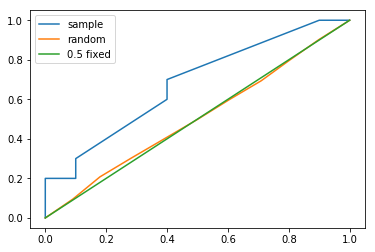

In [179]:
# 按照预测结果绘制
draw(data, label='sample')

# 将预测概率设置成随机数
data2 = np.c_[data[:, 0], np.random.random(data.shape[0])]
# 绘制随机结果
draw(data2, label='random')

# 所有概率都预测成0.5
data3 = np.c_[data[:, 0], np.array([0.5]*data.shape[0])]
draw(data3, label='0.5 fixed')


plt.legend()

从图中我们可以看到, 随机数概率基本上就是写对角线, 而固定0.5的概率之所以看起来是对角线, 因为XY值只有两种(0,0)和(1,1)。

### 计算AUC值

有了这个曲线以后, 我么要计算曲线下的面积就是AUC的值, 使用循环的方式, 把曲线下的面积分割为多个梯形, 然后累加每个梯形的面积即可:

In [199]:

def auc(data):
    N = 120
    XY = np.zeros((N, 2))
    for i in range(N):
        y = i / 10
        params = xy(metrics(data, y))
        XY[i, 0] = params['fpr']
        XY[i, 1] = params['tpr']
    pre_x = None
    pre_y = None
    area = 0
    for i in range(N):
        x = XY[i, 0]
        y = XY[i, 1]
        if pre_x != x and pre_x is not None:
            area += (y + pre_y)/2 * (pre_x-x)
        pre_x = x
        pre_y = y
    return area

auc(data)

0.9 1.0
0.4 0.7
0.1 0.3
0.0 0.2


0.6799999999999999